<a href="https://colab.research.google.com/github/HenrySomeCode/Classify-cifar-images-using-CNN/blob/main/Classify_cifar_images_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref:
* AI/ML/DL Course by Master Tuan Linh & TA

##Connect to driver and load package

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# load needed package
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os

## Unzip dataset file

In [ ]:
core_path = "/content/gdrive/MyDrive/AI_ML_DL Course_by_Master_Linh_HUST/week 5/cifar10"


In [ ]:
zip_path = core_path+'/data/cifar10.zip'
!cp "{zip_path}" .
!unzip -q cifar10.zip
!rm cifar10.zip

##Show data in train, val, test dataset

In [ ]:
def show_image(path):
  plt.subplots(figsize=(10,10))
  #use enumerate for adding a "count" to loop
  for count, folder_name in enumerate(os.listdir(path)):
    folder_path = os.path.join(path,folder_name)
    first_image_name = os.listdir(folder_path)[0]
    first_image_path = os.path.join(folder_path, first_image_name)

    plt.subplot(1,10,count+1)
    plt.xticks([]) # delete number on x-axis
    plt.yticks([]) # delete number on y-axis
    plt.xlabel(folder_name) # add name of that image
    plt.imshow(cv2.imread(first_image_path, cv2.IMREAD_UNCHANGED))
    # print(cv2.imread(first_image_path, cv2.IMREAD_UNCHANGED).shape)

  plt.show()


In [ ]:
train_path = "/content/cifar10/train"
val_path = "/content/cifar10/val"
test_path = "/content/cifar10/test"

<ipython-input-6-e60962ee95c8>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,count+1)


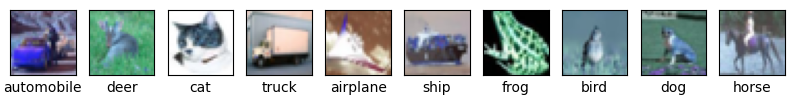

In [ ]:
show_image(train_path)

<ipython-input-6-e60962ee95c8>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,count+1)


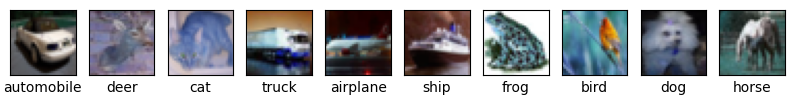

In [ ]:
show_image(val_path)

<ipython-input-6-e60962ee95c8>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,count+1)


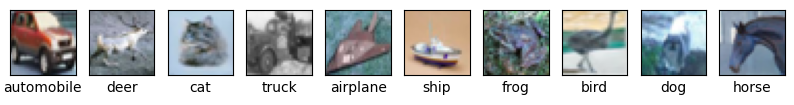

In [ ]:
show_image(test_path)

##Data Augmentation

In [ ]:
train_data_augmentation = ImageDataGenerator(
    brightness_range=[0.5,1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=[0.7,1.2],
    rescale = 1./255
)
val_data_rescale = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
 # target_size = (32,32) : The image shape in dataset is (32, 32, 3).
 # We still want the images output after augmentation are the same shape
 # with its original, so we set target_size = (32,32)
 # which represent for the width and height.
 # There's no set for chanel (3 in (32,32,3))

 # batch_size = 32. We want to divide 32000 images to batches.
 # Each batch contains 32 images. By doing that, each time we will
 # pass 32 images in training till finishing 32000 images

train_data = train_data_augmentation.flow_from_directory(
    train_path,
    target_size = (32,32),
    batch_size = 32,
    class_mode = "categorical"
)

val_data = val_data_rescale.flow_from_directory(
    val_path,
    target_size = (32,32),
    batch_size = 32,
    class_mode = "categorical"
)

In [ ]:
# these code for viewing image (train set) after agumentation, though we wouldn't see anything
# because the images is rescale

plt.figure(figsize=(10,8))
batch = next(train_data)
# print(batch[0])
image_ = batch[0].astype('uint8')
#print(image_.shape)
plt.imshow(image_[0])
plt.show()

##Building a CNN model

In [ ]:
def CNN_model (image_shape = (32,32,3)):
  input = Input(shape = image_shape)
  x = Conv2D(32, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(input)
  x = Conv2D(32, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = Conv2D(128, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(256, kernel_size = (3, 3), strides= 1, activation = "relu", padding = "same")(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)

  x = Flatten()(x)

  x = Dense(128, activation = "relu")(x)
  x = Dropout(0.2)(x)

  output = Dense(10, activation = "softmax")(x)

  model = Model(inputs = input, outputs = output)
  model.summary()

  return model

In [ ]:
model = CNN_model()
# Conv2D_ = 32*(3 * 3 * 3 + 1) = 896
# Conv2D_1 = 32*(3 * 3 * 32 + 1) = 9248
# Conv2d_2 = 64*(3*3*32 + 1) = 18496

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                             

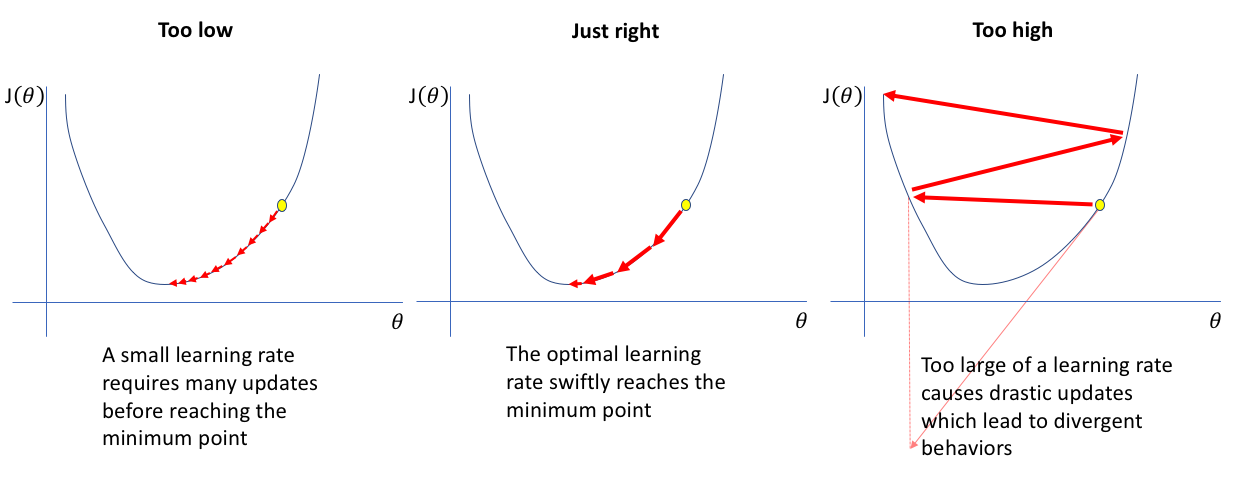

[Image for explaining ReduceLROnPlateau, Source: https://duchesnay.github.io/pystatsml/optimization/optim_gradient_descent.html ]

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ["accuracy"])
# min_lr -- lowest value that learning rate can be
# factor -- factor by which learning rate will be reduced
my_callback = [
    ReduceLROnPlateau(
        min_lr=0.0000001,
        factor = 0.1,
        patience=10,
        monitor="val_loss"),
    ModelCheckpoint(core_path+"/code/good_model/CNN_677738_{val_loss:}_{val_accuracy:}.hdf5",
                    monitor="val_accuracy",
                    save_best_only=True)]


In [ ]:
steps_per_epoch = 32000/32
validation_step = 8000/32
history = model.fit(train_data, batch_size=32, epochs = 200, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

In [ ]:
model = load_model(core_path+"/code/good_model/CNN_677738_0.5720173716545105_0.8066250085830688.hdf5")


In [ ]:
test_data = val_data_rescale.flow_from_directory(test_path, target_size = (32, 32), batch_size = 32, class_mode = "categorical")


Found 10000 images belonging to 10 classes.


In [ ]:
model.evaluate(test_data)

313/313 [==============================] - 13s 17ms/step - loss: 0.5560 - accuracy: 0.8105


[0.5559580326080322, 0.8105000257492065]